# Setup

In [1]:
# data manipulation and visualization
from random import sample
import polars as pl
import seaborn as sns

# model fitting and tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TunedThresholdClassifierCV

# model evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [2]:
train_data = pl.read_excel("recruiting_zeta-disease_training-data_take-home-challenge.xlsx")
prediction_data = pl.read_excel("recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx")

In [3]:
# create train and test splits
rows_idx = list(range(train_data.shape[0]))
train_idx = sample(rows_idx, k=round(train_data.shape[0] * 0.75))
test_idx = list(set(rows_idx) - set(train_idx))

train = train_data[train_idx]
test = train_data[test_idx]

In [4]:
train.shape, test.shape

((600, 9), (200, 9))

# EDA

In [5]:
train

age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
i64,i64,f64,i64,i64,f64,i64,i64,i64
22,134,31.9,68,106,0.6538,60,3,0
18,184,26.4,58,291,0.4148,50,0,0
22,131,30.1,72,76,0.6098,45,2,0
19,201,26.1,60,0,0.2418,0,1,0
27,197,34.9,74,293,0.4478,55,4,0
…,…,…,…,…,…,…,…,…
22,128,33.7,48,0,0.7168,0,5,0
21,158,35.5,60,178,0.4778,76,1,0
41,142,27.6,62,258,0.9888,37,12,1


In [6]:
train.describe()

statistic,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",31.1,173.346667,32.323667,69.943333,87.52,0.546649,43.605,4.081667,0.358333
"""std""",14.148509,32.028991,8.569674,19.429599,132.756532,0.367543,31.120569,4.180206,0.479911
"""min""",18.0,106.0,0.0,0.0,0.0,0.1408,0.0,0.0,0.0
"""25%""",21.0,150.0,27.3,64.0,0.0,0.2998,0.0,1.0,0.0
"""50%""",26.0,169.0,32.4,72.0,40.0,0.4338,53.0,3.0,0.0
"""75%""",38.0,193.0,36.6,80.0,132.0,0.7118,62.0,6.0,1.0
"""max""",109.0,295.0,86.1,157.0,1077.0,3.4813,214.0,38.0,1.0


In [7]:
prediction_data.describe()

statistic,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
str,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""",20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,"""0"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""20"""
"""mean""",34.75,178.8,34.48,78.5,145.05,1.5696,61.95,6.05,null
"""std""",11.511436,27.935264,6.628773,14.005638,75.964309,0.230356,9.703363,3.471311,null
"""min""",19.0,120.0,25.8,59.0,50.0,1.2498,43.0,2.0,null
"""25%""",27.0,154.0,30.4,70.0,77.0,1.4168,56.0,3.0,null
"""50%""",35.0,193.0,33.9,73.0,141.0,1.4878,60.0,6.0,null
"""75%""",44.0,197.0,37.4,89.0,167.0,1.7238,68.0,7.0,null
"""max""",60.0,216.0,50.7,108.0,362.0,2.0508,83.0,13.0,null


data appears well-behaved
* no missing values in predictors
* test set ranges do not exceed train set ranges
* distributions seem reasonably similar, though the `*_test` columns are a little off; could just be down to small sample size
* slight level of imbalance in target variable

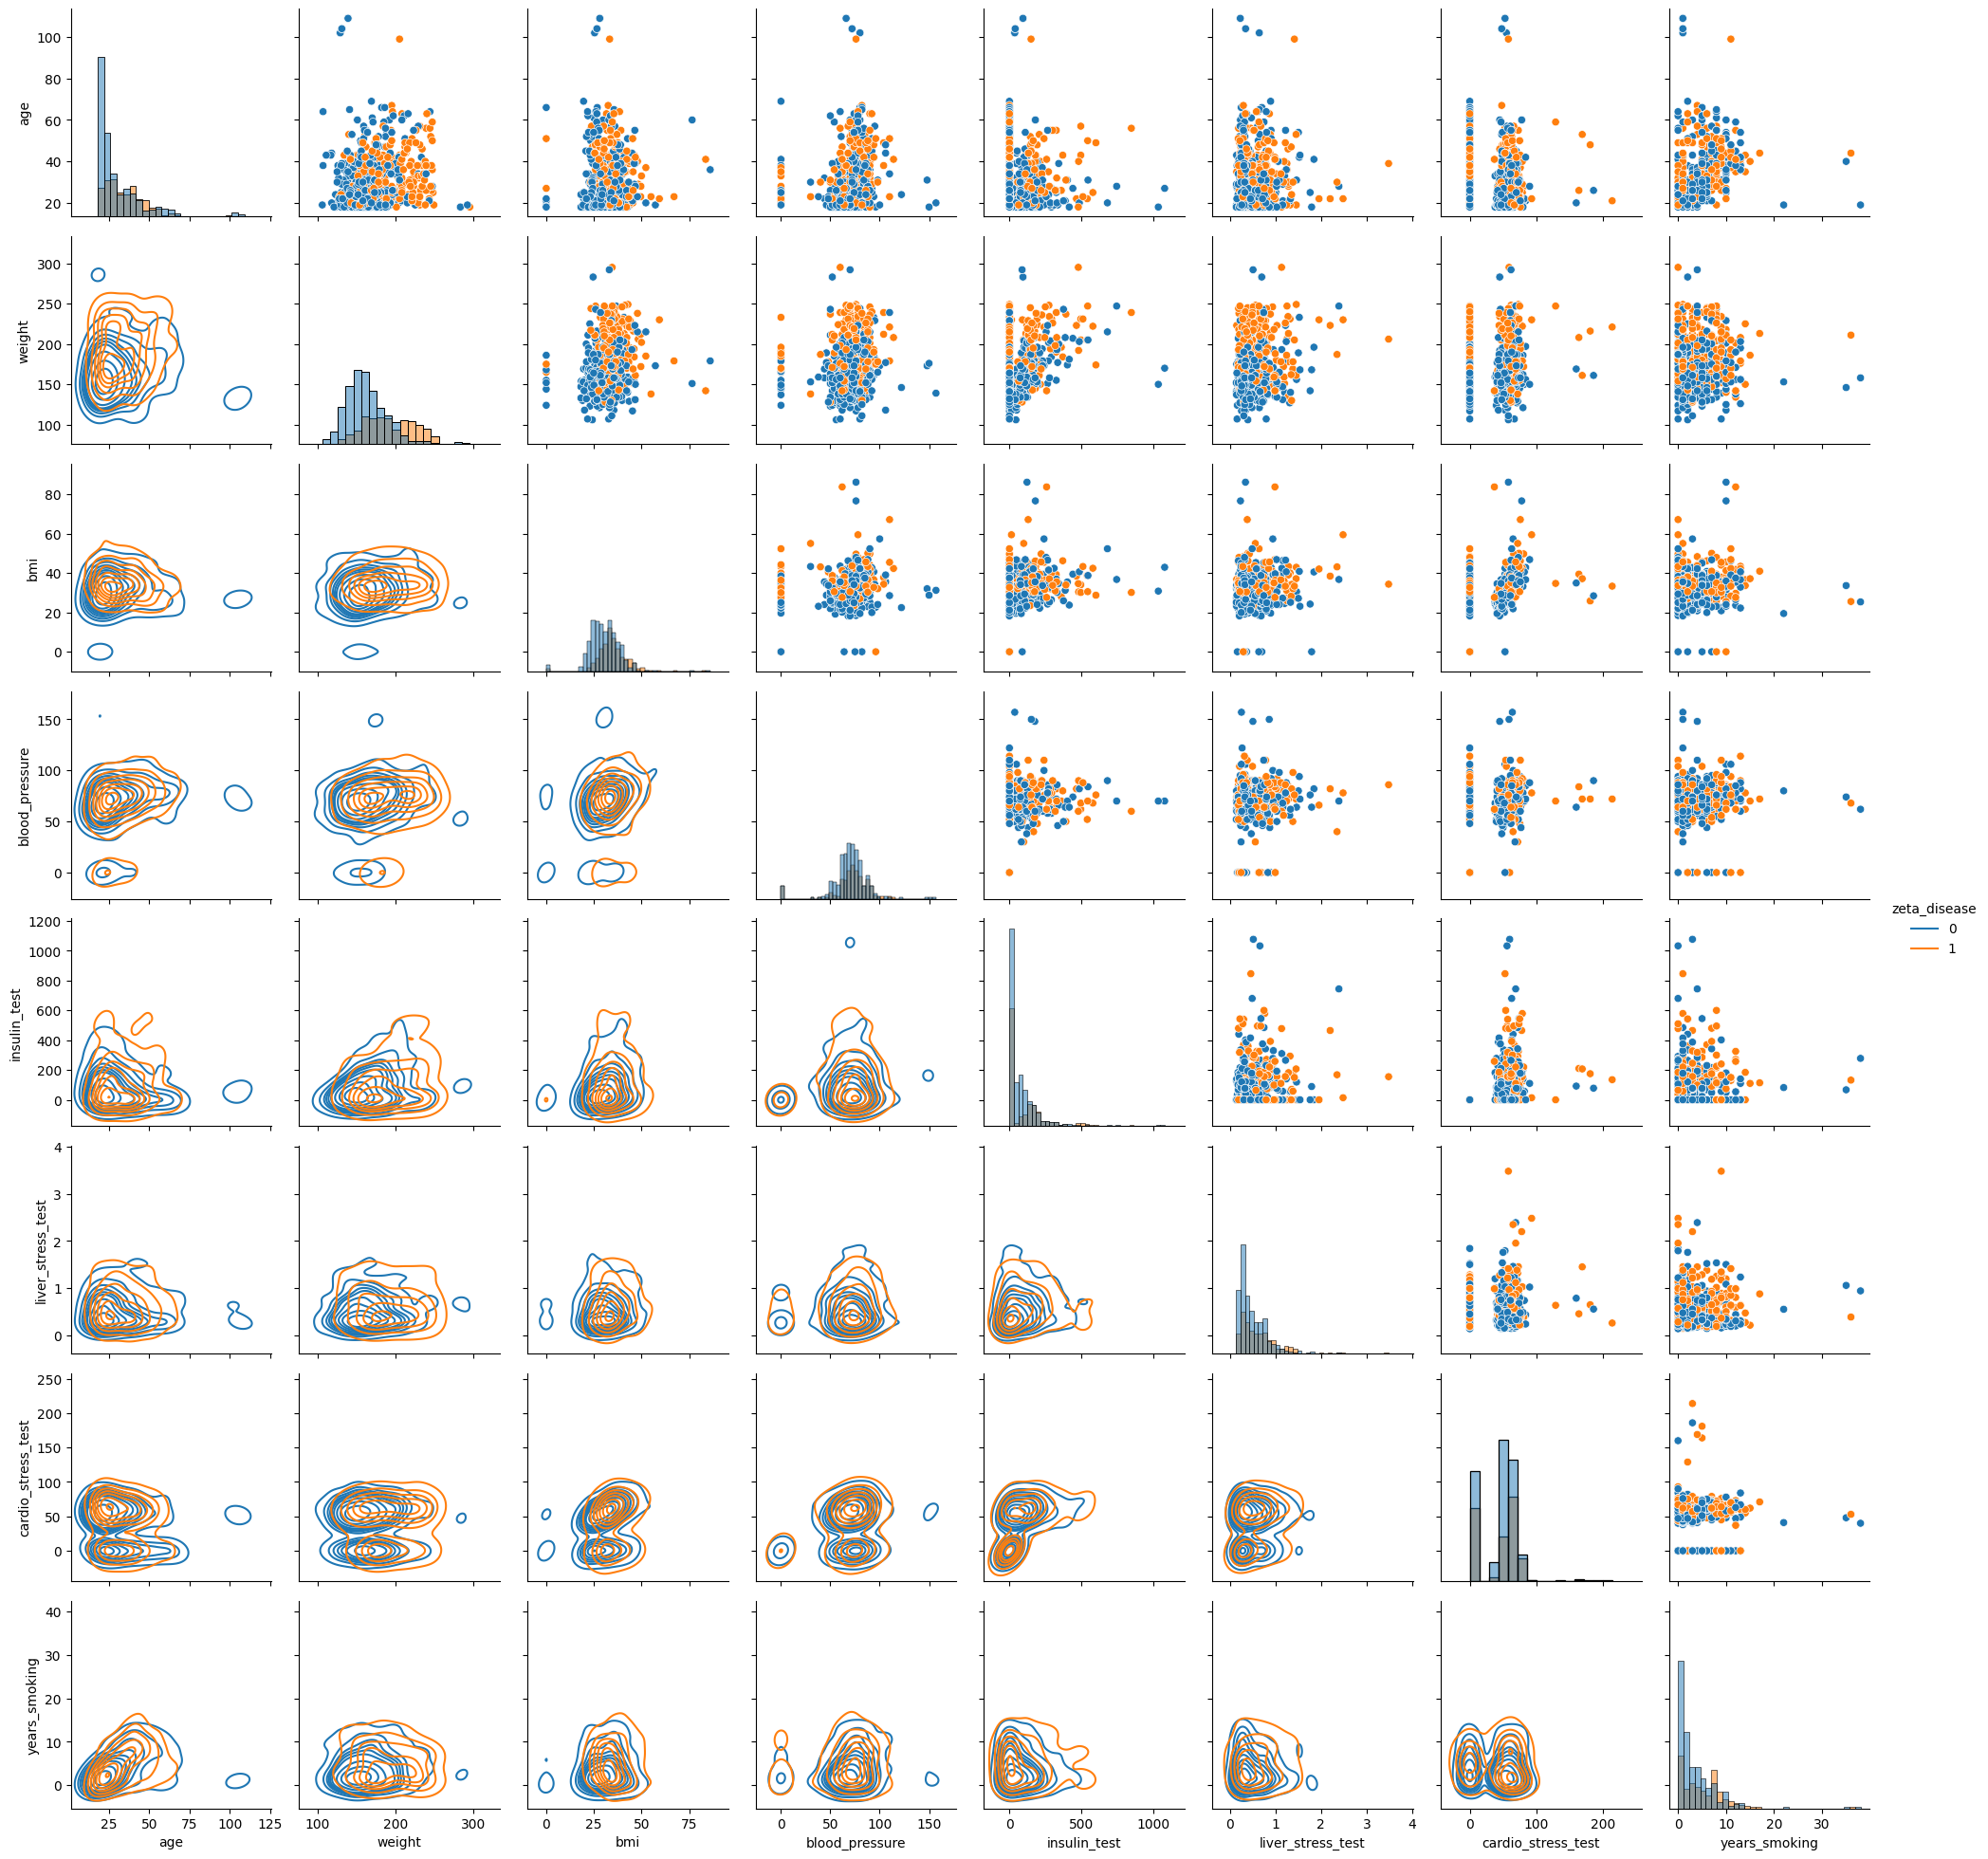

In [8]:
g = sns.PairGrid(train, hue="zeta_disease")
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

* no egregious collinearity among predictors
* no wild outliers (though `years_smoking` has a few borderline points)
* `weight` looks to be the predictor with the most individual discriminatory power for disease status, so expect combinatorics to be important for predictive power

In [9]:
X = train.drop("zeta_disease").to_numpy()
y = train.select("zeta_disease").to_numpy().squeeze()

X_test = test.drop("zeta_disease").to_numpy()
y_test = test.select("zeta_disease").to_numpy().squeeze()

# Training pipeline

## Hyperparameter tuning

In [10]:
# random forest to capture combinatorics
# with more time, could experiment with more algorithms, also ensembling or stacking
base_estimator = RandomForestClassifier(random_state=42)

# range of regularization strengths over different aspects of model
param_grid = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [2, 4, 8, 16],
    "min_samples_leaf": [1, 2, 4, 8]
}

# stratified CV to account for class imbalance
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# brute force search since data is small
search = GridSearchCV(
    estimator=base_estimator,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=8
)

search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=8,
             param_grid={'max_depth': [2, 4, 8, 16],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='roc_auc')

In [11]:
print(f"best roc_auc: {search.best_score_:.3f}")

best roc_auc: 0.838


In [12]:
search.best_params_

{'max_depth': 8, 'min_samples_leaf': 8, 'n_estimators': 100}

In [13]:
cv_results = pl.DataFrame(
    search.cv_results_
).select(
    pl.col("^param_.*$"),
    pl.col("mean_test_score"),
    pl.col("std_test_score")
)

<Axes: xlabel='mean_test_score', ylabel='Count'>

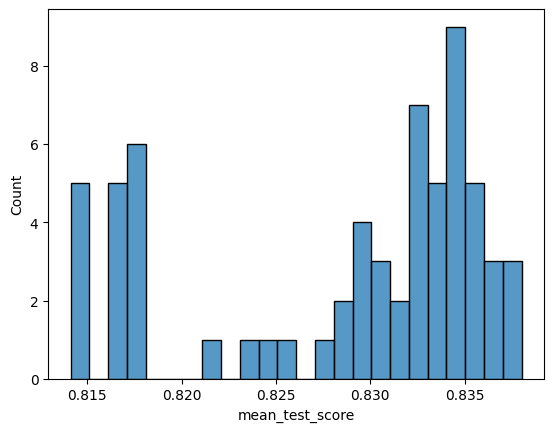

In [14]:
sns.histplot(cv_results, x="mean_test_score", binwidth=0.001)

<Axes: xlabel='param_n_estimators', ylabel='mean_test_score'>

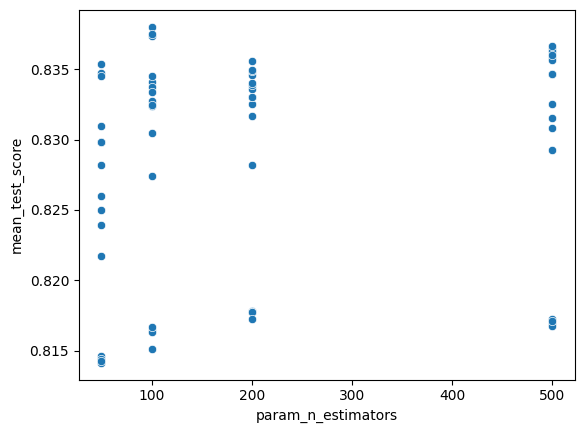

In [15]:
sns.scatterplot(cv_results, x="param_n_estimators", y="mean_test_score")

<Axes: xlabel='param_max_depth', ylabel='mean_test_score'>

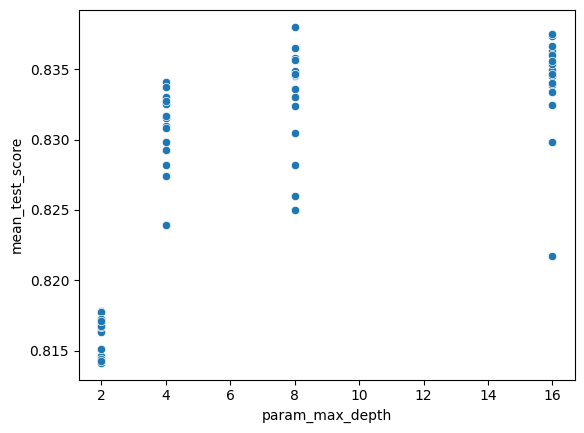

In [16]:
sns.scatterplot(cv_results, x="param_max_depth", y="mean_test_score")

<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

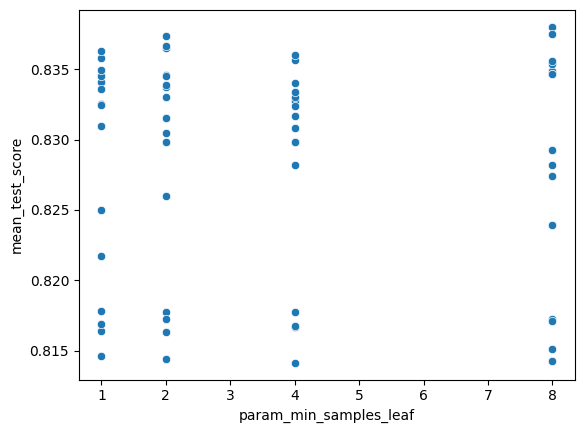

In [17]:
sns.scatterplot(cv_results, x="param_min_samples_leaf", y="mean_test_score")

Model is relatively insensitive to hyperparameters, as expected for random forests.  Decision stumps are the exception and do not perform as well, which we anticipated from the EDA.

## Decision threshold tuning

In [18]:
# optimize the probability threshold for classification
# we don't know the relative costs of false positives or false negatives, 
# so we'll use the default balanced accuracy as the metric
tuned_model = RandomForestClassifier(
    n_estimators=search.best_params_["n_estimators"],
    max_depth=search.best_params_["max_depth"],
    min_samples_leaf=search.best_params_["min_samples_leaf"],
    n_jobs=1
)

threshold_model = TunedThresholdClassifierCV(
    tuned_model, 
    thresholds=50,
    n_jobs=8
)

threshold_model.fit(X, y)

TunedThresholdClassifierCV(estimator=RandomForestClassifier(max_depth=8,
                                                            min_samples_leaf=8,
                                                            n_jobs=1),
                           n_jobs=8, thresholds=50)

In [19]:
print(f"tuned probability threshold: {threshold_model.best_threshold_:.3f}")

tuned probability threshold: 0.355


# Evaluation

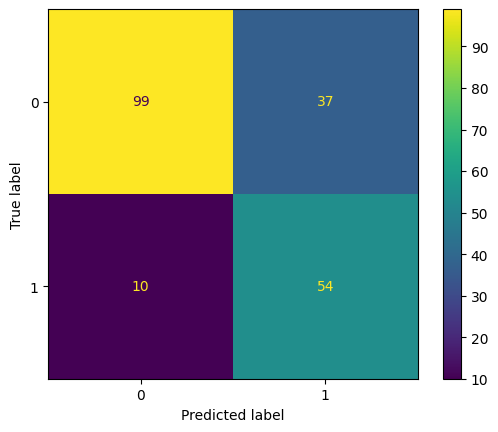

In [20]:
ConfusionMatrixDisplay.from_estimator(threshold_model, X_test, y_test)

In [21]:
print(classification_report(y_test, threshold_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81       136
           1       0.59      0.84      0.70        64

    accuracy                           0.77       200
   macro avg       0.75      0.79      0.75       200
weighted avg       0.81      0.77      0.77       200



/tmp/ipykernel_319087/4244800380.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


[Text(0, 0, 'age'),
 Text(1, 0, 'weight'),
 Text(2, 0, 'bmi'),
 Text(3, 0, 'blood_pressure'),
 Text(4, 0, 'insulin_test'),
 Text(5, 0, 'liver_stress_test'),
 Text(6, 0, 'cardio_stress_test'),
 Text(7, 0, 'years_smoking')]

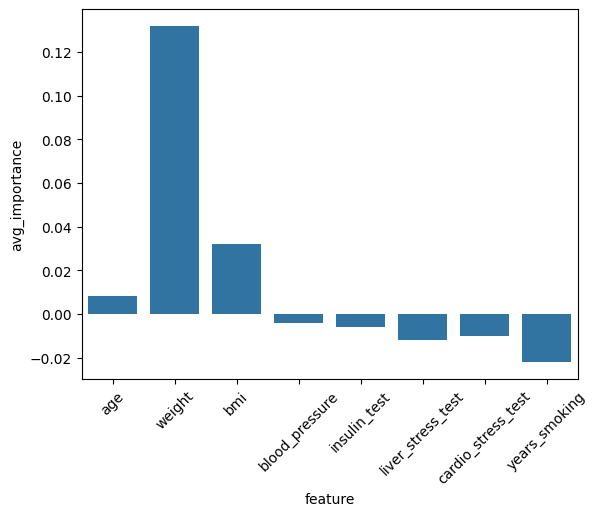

In [22]:
imp = permutation_importance(threshold_model, X_test, y_test, n_repeats=5, n_jobs=8)

imp_df = pl.DataFrame({
    "feature": train.columns[:-1],
    "avg_importance": imp.importances_mean
})

p = sns.barplot(
    imp_df,
    x="feature",
    y="avg_importance"
)
p.set_xticklabels(p.get_xticklabels(), rotation=45)

Overall, results are OK, but definitely some room for improvement.  However, based on the level of signal from the predictors apparent in the EDA, this may be close to the upper bound of accuracy we might expect to get from this training data.

Things worth exploring with a little more time:
* removing non-predictive variables and re-training model
* experimentation with multiple algorithms
* ensembling or stacking models

# Final model

In [23]:
# retrain model with best parameters on all available data
final_model = RandomForestClassifier(
    n_estimators=search.best_params_["n_estimators"],
    max_depth=search.best_params_["max_depth"],
    min_samples_leaf=search.best_params_["min_samples_leaf"],
    n_jobs=8
).fit(
    train_data.drop("zeta_disease").to_numpy(), 
    train_data.select("zeta_disease").to_numpy().squeeze()
)

# Prediction

In [24]:
X_pred = prediction_data.drop("zeta_disease").to_numpy()
pred_probs = final_model.predict_proba(X_pred)
(pred_probs[:,1] > threshold_model.best_threshold_).astype(int)

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])